<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [28]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
listings = pd.read_csv("./data/job_listings.csv", index_col=0)
listings.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [29]:
#should create a fxn to clean the df: html tags, /n, ascii/unicode?, 
def magic_eraser(text):
    soup = BeautifulSoup(text, 'html.parser')
    string = soup.get_text()
    clean = string.replace('\n', ' ')
    
    return clean

In [35]:
listings["description"] = listings["description"].apply(magic_eraser)
#listings["description"] = listings["description"].replace('\n',' ', regex=True)
listings.head()
#can't get /ns removed, need to work more on this later

,description,title,tokens
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""job, requirements:\nconceptual, understandi..."
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'job, description\n\nas, data, scientist, 1,..."
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'as, data, scientist, working, consulting, b..."
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, -, $6,756, monthcontractunder, gene..."
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 2) Use Spacy to tokenize the listings 

In [31]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [34]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'i', "it's","a","b","c","and"])
tokens = []
for text in tokenizer.pipe(listings["description"], batch_size=500):
    text_tokens = []
    
    for token in text: 
        if token.text.lower() not in STOP_WORDS:
            text_tokens.append(token.text.lower())
   
    tokens.append(text_tokens)

listings['tokens'] = tokens
listings['tokens'].head()

0    [b"job, requirements:\nconceptual, understandi...
1    [b'job, description\n\nas, data, scientist, 1,...
2    [b'as, data, scientist, working, consulting, b...
3    [b'$4,969, -, $6,756, monthcontractunder, gene...
4    [b'location:, usa, \xe2\x80\x93, multiple, loc...
Name: tokens, dtype: object

In [40]:
listings.head()

,description,title,tokens
0,"b""Job Requirements:\nConceptual understanding ...",Data scientist,"[b""job, requirements:\nconceptual, understandi..."
1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I,"[b'job, description\n\nas, data, scientist, 1,..."
2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[b'as, data, scientist, working, consulting, b..."
3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[b'$4,969, -, $6,756, monthcontractunder, gene..."
4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[b'location:, usa, \xe2\x80\x93, multiple, loc..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [43]:
# CountVectorizer already imported
vect = CountVectorizer(stop_words='english')

# get the vocab for listings
vect.fit(listings["description"])
dtm = vect.transform(listings["description"])
# get word counts
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
#dtm

## 4) Visualize the most common word counts

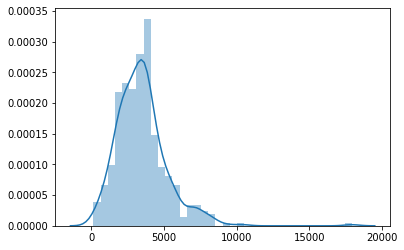

In [45]:
import seaborn as sns
doc_len = [len(doc) for doc in listings["description"]]
sns.distplot(doc_len);

In [46]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

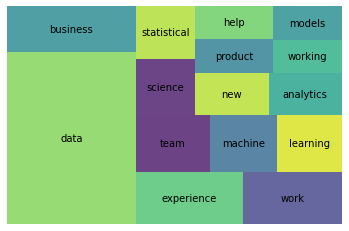

In [48]:
#top 15 words mentioned in the listings
import matplotlib.pyplot as plt
import squarify
wc = count(listings['tokens'])
top15 = wc[wc["rank"] <= 15]

squarify.plot(sizes=top15["pct_total"], label=top15["word"], alpha=.8)
plt.axis("off")
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [49]:
# TfidfVectorizer already imported
# instantiate vectorizer 
tfidf = TfidfVectorizer(stop_words="english")

# get the vocab
dtm = tfidf.fit_transform(listings["description"])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104421,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [50]:
from sklearn.neighbors import NearestNeighbors

In [51]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [54]:
# query
nn.kneighbors([dtm.iloc[42]])

(array([[0.        , 0.        , 1.21944738, 1.27602753, 1.27602753]]),
 array([[138,  42, 226,  52, 142]]))

In [57]:
my_ds_job = ["""
Data Scientist, Machine Learning to join our Global Insights team. Entertainment Studio Development data scientists design and deploy data-powered products and services that scale to the terabytes of data that games generate every day. The ideal candidate is passionate about the latest innovations in machine learning, artificial intelligence, statistics, and deep learning; has expertise in designing highly scalable machine learning algorithms; with strong programming skill to help deploy and maintain them.
"""]

In [58]:
# query dream job
job = tfidf.transform(my_ds_job)
nn.kneighbors(job.todense())

(array([[1.27071019, 1.2783925 , 1.2783925 , 1.28109793, 1.28666759]]),
 array([[151, 142,  52, 201, 252]]))

In [59]:
#check out the most relevant listings the model found
listings["description"][151]

"b'The Data Scientist is a critical position within DSS and in the Data organization who specializes in applying machine learning methods to meet optimization, personalization, recommendations and efficiency related challenges, in close collaboration with engineering and business partners. In this role, you will build and apply machine learning techniques and modern statistics to data both augment decision-making but to also significantly improve operational process problems through automation. You will collaborate across teams to define problems and develop automated solutions with the Data, Product and Engineering teams to be built into our products.\\n\\nResponsibilities :\\nReframe objectives as machine learning tasks that can deliver actionable insights, accurate predictions, and effective optimization.\\nImplement and execute machine learning with reliability and reproducibility.\\nExplain how models and systems work to both non-technical and technical stakeholders.\\nCollaborate

In [60]:
# 2nd best
listings["description"][142]

'b"The challenge\\nAdobe is looking for a Senior Data Scientist who will be building the next generation of marketing cloud products by leveraging machine learning, predictive modeling and optimization techniques. These products would help businesses understand, manage, and optimize the experience throughout the customer journey. Example applications include real-time online media optimization, media attribution, predictive sales analytics, product recommendation, mobile analytics, predictive customer scoring and segmentation and large-scale experimentation.\\nIdeal candidates will have a strong academic background as well as technical skills including applied statistics, machine learning, data mining, and software development. Familiarity working with large-scale datasets and big data techniques would be a plus.\\nWhat you\\xe2\\x80\\x99ll do\\nDevelop predictive models on large-scale datasets to address various business problems through leveraging advanced statistical modeling, machi

In [63]:
#5th 
listings["description"][252]

"b'InternshipPosition Description\\nThe candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machine learning / deep learning approaches can be applied to the E-commerce domain.\\nMinimum Qualifications\\nMachine learning, algorithm, data structure.\\nAdditional Preferred Qualifications\\nPlease add text\\nCompany Summary\\nThe Walmart eCommerce team is rapidly innovating to evolve and define the future state of shopping. As the world\\xe2\\x80\\x99s largest retailer, we are on a mission to help people save money and live better. With the help of some of the brightest minds in technology, merchandising, marketing, supply chain, talent and more, we are reimagining the intersection of digital and physical shopping to help achieve that mission.\\nPosition Summary\\nThe candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 